# **Feature Extraction and Classification**  

**By:** Pedro Ruiz  

---  

Este notebook tiene como objetivo realizar la **extracción de características** y la **clasificación** de imágenes en video mediante un modelo *finetuneado* (**ResNet50**).  

El enfoque incluye **replicar la jerarquía de directorios** de `processed/` en `detection_results/`, asegurando una estructura **clara y organizada** para los resultados. Además, se ajustará el formato de salida del **CSV** para **evitar redundancias** en los nombres de archivo.  

Se llevarán a cabo las siguientes operaciones:  

1. **Importaciones**  
2. **Configuración**  
3. **Preparación del modelo**  
4. **Preprocesamiento de imágenes**  
5. **Clasificación de frames**  
6. **Visualización de resultados**  

## 1. Importaciones  

In [1]:
import math
import os
import random
import configparser
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms, models

## 2. Configuración  

Definimos las **condiciones necesarias** para configurar el modelo, incluyendo la **carga de los pesos finetuneados** y los **directorios de trabajo**.

In [2]:
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

config = configparser.ConfigParser()
config_path = os.path.join(project_root, 'config', 'settings.conf')
config.read(config_path)

processed_data_path = os.path.join(project_root, config['data']['processed_data_path'])
detection_results_path = os.path.join(project_root, config['data']['detection_results_path'])
transfers_path = os.path.join(project_root, config['data']['transfers_path'])
best_model_path = os.path.join(transfers_path, 'resnet_finetuned.pth')
os.makedirs(detection_results_path, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


## 3. Preparación del Modelo  

Cargamos el modelo **ResNet50 finetuneado** y configuramos las **transformaciones de preprocesamiento**. 

In [11]:
# Cargar el modelo finetuneado
checkpoint = torch.load(best_model_path, map_location=device, weights_only=True)            # Carga el checkpoint finetuneado
class_names = checkpoint['class_names']                                                     # y recupera los nombres de las clases.

model = models.resnet50(weights=None)                                                       # Inicializamos el ResNet-50 sin pesos,
in_features = model.fc.in_features                                                          # extraemos el número de características de entrada de la capa fully connected,
model.fc = torch.nn.Linear(in_features, len(class_names))                                   # reemplazamos la capa fully connected por nuestro numero de clases,
model.load_state_dict(checkpoint['model_state_dict'])                                       # cargamos los pesos guardados del checkpoint,
model.eval().to(device)                                                                     # y podemos el modelo en modo de evaluación y lo movemos al dispositivo.

transform = transforms.Compose([                                                            # Definimos las transformaciones que se aplicarán a las imágenes.
    transforms.Resize((224, 224)),                                                          # Cambiando su tamaño a 224x224 píxeles,
    transforms.ToTensor(),                                                                  # las transformamos a tensores,
    transforms.Normalize(mean=[0.485, 0.456, 0.406],                                        # normaliza los valores de los píxeles con las medias estándar de ImageNet 
                         std=[0.229, 0.224, 0.225])                                         # y las aplicamos las desviaciones estándar correspondientes.
])

## 4. Preprocesamiento y Clasificación de Frames  

Definimos la **función principal** para **procesar los frames de video** y **clasificar las imágenes**, generando un archivo **CSV por video**.  

In [ ]:
def process_video(video_dir, output_csv_path):
    frames = [f for f in os.listdir(video_dir) if f.endswith('.jpg')]                       # iteramos para obtener todos los archivos con extensión .jpg del directorio,
    frames.sort()                                                                           # y nos aseguramos de que estén ordenados.

    results = []                                                                            # Inicializamos una lista para almacenar los resultados.
    for frame_name in tqdm(frames, desc=f"Procesando {os.path.basename(video_dir)}"):       # e iteramos sobre los frames del video con un mensaje de progreso.
        frame_path = os.path.join(video_dir, frame_name)                                    # Construimos la ruta completa del frame,
        img = Image.open(frame_path).convert("RGB")                                         # Cargamos la imagen y la convertimos a RGB,
        img_t = transform(img).unsqueeze(0).to(device)                                      # aplicamos las transformaciones, una dimensión batch y lo movemos al dispositivo.
        with torch.no_grad():                                                               # Desactivamos el cálculo de gradientes (ahorrando memoria y acelerando el procesamiento)
            logits = model(img_t)                                                           # Generamos  las predicciones,
            probs = F.softmax(logits, dim=1)                                                # transformamos los logits en probabilidades,
            conf, pred = probs.max(dim=1)                                                   # y obtenemos la clase predicha y la confianza,
            predicted_class = class_names[pred.item()]                                      # Obtenemos el nombre de la clase predicha,
            results.append([frame_name, predicted_class, conf.item()])                      # y guardamos el nombre del frame, la clase predicha y la confianza en la lista de resultados.

    df = pd.DataFrame(results, columns=["frame_id", "predicted_class", "confidence"])       # Creamos un conjunto de datos para los resultados,
    df.to_csv(output_csv_path, index=False)                                                 # y lo guardamos en un CSV.
    print(f"Guardado CSV en {output_csv_path}")

print(f"Explorando {processed_data_path}")
for category in os.listdir(processed_data_path):                                            # Iteramos sobre las categorías en el directorio raiz,
    category_path = os.path.join(processed_data_path, category)                             # construimos la ruta de las categoría,
    if os.path.isdir(category_path):                                                        # y verificamos que sea un directorio.
        print(f"Procesando: {category}")

        # Creamos el directorio
        category_output_dir = os.path.join(detection_results_path, category)
        os.makedirs(category_output_dir, exist_ok=True)

        for video_dir in os.listdir(category_path):                                         # Iteramos sobre los directorios de las categorías,
            video_path = os.path.join(category_path, video_dir)                             # construimos la ruta del video,
            if os.path.isdir(video_path):                                                   # verificamos si es un directorio.
                output_csv = os.path.join(category_output_dir, f"{video_dir}.csv")          # Definimos la ruta para el CSV de salida para el video y
                process_video(video_path, output_csv)                                       # procesamos.

Explorando ../data/processed
Procesando: cooking


Procesando cooking_000001: 100%|██████████| 754/754 [00:05<00:00, 144.15it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000001.csv


Procesando cooking_000002: 100%|██████████| 1172/1172 [00:07<00:00, 149.79it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000002.csv


Procesando cooking_000003: 100%|██████████| 270/270 [00:01<00:00, 151.35it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000003.csv


Procesando cooking_000004: 100%|██████████| 843/843 [00:05<00:00, 151.74it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000004.csv


Procesando cooking_000005: 100%|██████████| 534/534 [00:03<00:00, 151.71it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000005.csv


Procesando cooking_000006: 100%|██████████| 800/800 [00:05<00:00, 152.87it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000006.csv


Procesando cooking_000007: 100%|██████████| 1068/1068 [00:07<00:00, 149.86it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000007.csv


Procesando cooking_000008: 100%|██████████| 1122/1122 [00:07<00:00, 148.53it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000008.csv


Procesando cooking_000009: 100%|██████████| 674/674 [00:04<00:00, 156.25it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000009.csv


Procesando cooking_000010: 100%|██████████| 1301/1301 [00:08<00:00, 154.60it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000010.csv


Procesando cooking_000011: 100%|██████████| 972/972 [00:06<00:00, 154.16it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000011.csv


Procesando cooking_000012: 100%|██████████| 527/527 [00:03<00:00, 148.88it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000012.csv


Procesando cooking_000013: 100%|██████████| 620/620 [00:04<00:00, 144.79it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000013.csv


Procesando cooking_000014: 100%|██████████| 411/411 [00:02<00:00, 151.48it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000014.csv


Procesando cooking_000015: 100%|██████████| 386/386 [00:02<00:00, 143.00it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000015.csv


Procesando cooking_000016: 100%|██████████| 1181/1181 [00:08<00:00, 146.04it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000016.csv


Procesando cooking_000017: 100%|██████████| 546/546 [00:03<00:00, 145.71it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000017.csv


Procesando cooking_000018: 100%|██████████| 520/520 [00:03<00:00, 151.30it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000018.csv


Procesando cooking_000019: 100%|██████████| 505/505 [00:03<00:00, 154.81it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000019.csv


Procesando cooking_000020: 100%|██████████| 330/330 [00:02<00:00, 150.06it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000020.csv


Procesando cooking_000021: 100%|██████████| 863/863 [00:06<00:00, 134.78it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000021.csv


Procesando cooking_000022: 100%|██████████| 512/512 [00:03<00:00, 139.89it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000022.csv


Procesando cooking_000023: 100%|██████████| 906/906 [00:06<00:00, 134.11it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000023.csv


Procesando cooking_000024: 100%|██████████| 497/497 [00:03<00:00, 131.82it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000024.csv


Procesando cooking_000025: 100%|██████████| 670/670 [00:04<00:00, 137.48it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000025.csv


Procesando cooking_000026: 100%|██████████| 590/590 [00:04<00:00, 136.90it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000026.csv


Procesando cooking_000027: 100%|██████████| 481/481 [00:03<00:00, 141.01it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000027.csv


Procesando cooking_000028: 100%|██████████| 598/598 [00:04<00:00, 128.42it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000028.csv


Procesando cooking_000029: 100%|██████████| 1457/1457 [00:10<00:00, 135.81it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000029.csv


Procesando cooking_000030: 100%|██████████| 1073/1073 [00:07<00:00, 134.32it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000030.csv


Procesando cooking_000031: 100%|██████████| 1077/1077 [00:07<00:00, 135.57it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000031.csv


Procesando cooking_000032: 100%|██████████| 295/295 [00:02<00:00, 134.41it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000032.csv


Procesando cooking_000033: 100%|██████████| 993/993 [00:07<00:00, 133.65it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000033.csv


Procesando cooking_000034: 100%|██████████| 992/992 [00:07<00:00, 134.92it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000034.csv


Procesando cooking_000035: 100%|██████████| 1107/1107 [00:08<00:00, 137.03it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000035.csv


Procesando cooking_000036: 100%|██████████| 229/229 [00:01<00:00, 140.31it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000036.csv


Procesando cooking_000037: 100%|██████████| 780/780 [00:05<00:00, 135.89it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000037.csv


Procesando cooking_000038: 100%|██████████| 766/766 [00:05<00:00, 140.32it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000038.csv


Procesando cooking_000039: 100%|██████████| 996/996 [00:07<00:00, 134.93it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000039.csv


Procesando cooking_000040: 100%|██████████| 750/750 [00:05<00:00, 136.52it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000040.csv


Procesando cooking_000041: 100%|██████████| 705/705 [00:05<00:00, 134.90it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000041.csv


Procesando cooking_000042: 100%|██████████| 798/798 [00:05<00:00, 133.94it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000042.csv


Procesando cooking_000043: 100%|██████████| 869/869 [00:06<00:00, 139.57it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000043.csv


Procesando cooking_000044: 100%|██████████| 708/708 [00:05<00:00, 132.56it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000044.csv


Procesando cooking_000045: 100%|██████████| 22/22 [00:00<00:00, 129.94it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000045.csv


Procesando cooking_000046: 100%|██████████| 1006/1006 [00:07<00:00, 141.14it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000046.csv


Procesando cooking_000047: 100%|██████████| 735/735 [00:04<00:00, 148.66it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000047.csv


Procesando cooking_000048: 100%|██████████| 1188/1188 [00:08<00:00, 148.02it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000048.csv


Procesando cooking_000049: 100%|██████████| 456/456 [00:03<00:00, 144.36it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000049.csv


Procesando cooking_000050: 100%|██████████| 876/876 [00:06<00:00, 143.73it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000050.csv


Procesando cooking_000051: 100%|██████████| 1108/1108 [00:07<00:00, 151.25it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000051.csv


Procesando cooking_000052: 100%|██████████| 978/978 [00:06<00:00, 153.54it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000052.csv


Procesando cooking_000053: 100%|██████████| 758/758 [00:04<00:00, 152.98it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000053.csv


Procesando cooking_000054: 100%|██████████| 758/758 [00:04<00:00, 155.62it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000054.csv


Procesando cooking_000055: 100%|██████████| 678/678 [00:04<00:00, 155.11it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000055.csv


Procesando cooking_000056: 100%|██████████| 982/982 [00:06<00:00, 149.85it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000056.csv


Procesando cooking_000057: 100%|██████████| 1072/1072 [00:06<00:00, 153.90it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000057.csv


Procesando cooking_000058: 100%|██████████| 1072/1072 [00:07<00:00, 150.39it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000058.csv


Procesando cooking_000059: 100%|██████████| 386/386 [00:02<00:00, 132.84it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000059.csv


Procesando cooking_000060: 100%|██████████| 482/482 [00:03<00:00, 142.73it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000060.csv


Procesando cooking_000061: 100%|██████████| 1054/1054 [00:07<00:00, 135.92it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000061.csv


Procesando cooking_000062: 100%|██████████| 577/577 [00:04<00:00, 135.50it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000062.csv


Procesando cooking_000063: 100%|██████████| 251/251 [00:01<00:00, 139.86it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000063.csv


Procesando cooking_000064: 100%|██████████| 875/875 [00:06<00:00, 140.39it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000064.csv


Procesando cooking_000065: 100%|██████████| 546/546 [00:03<00:00, 145.15it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000065.csv


Procesando cooking_000066: 100%|██████████| 405/405 [00:02<00:00, 146.84it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000066.csv


Procesando cooking_000067: 100%|██████████| 919/919 [00:06<00:00, 142.19it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000067.csv


Procesando cooking_000068: 100%|██████████| 651/651 [00:04<00:00, 150.88it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000068.csv


Procesando cooking_000069: 100%|██████████| 1808/1808 [00:12<00:00, 143.64it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000069.csv


Procesando cooking_000070: 100%|██████████| 1418/1418 [00:10<00:00, 140.98it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000070.csv


Procesando cooking_000071: 100%|██████████| 133/133 [00:00<00:00, 141.36it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000071.csv


Procesando cooking_000072: 100%|██████████| 205/205 [00:01<00:00, 143.37it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000072.csv


Procesando cooking_000073: 100%|██████████| 678/678 [00:04<00:00, 148.78it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000073.csv


Procesando cooking_000074: 100%|██████████| 358/358 [00:02<00:00, 145.27it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000074.csv


Procesando cooking_000075: 100%|██████████| 105/105 [00:00<00:00, 145.79it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000075.csv


Procesando cooking_000076: 100%|██████████| 745/745 [00:04<00:00, 149.28it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000076.csv


Procesando cooking_000077: 100%|██████████| 220/220 [00:01<00:00, 157.75it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000077.csv


Procesando cooking_000078: 100%|██████████| 453/453 [00:03<00:00, 147.58it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000078.csv


Procesando cooking_000079: 100%|██████████| 787/787 [00:05<00:00, 150.13it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000079.csv


Procesando cooking_000080: 100%|██████████| 473/473 [00:03<00:00, 156.74it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000080.csv


Procesando cooking_000081: 100%|██████████| 385/385 [00:02<00:00, 149.22it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000081.csv


Procesando cooking_000082: 100%|██████████| 1101/1101 [00:07<00:00, 138.98it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000082.csv


Procesando cooking_000083: 100%|██████████| 220/220 [00:01<00:00, 144.40it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000083.csv


Procesando cooking_000084: 100%|██████████| 606/606 [00:04<00:00, 150.35it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000084.csv


Procesando cooking_000085: 100%|██████████| 594/594 [00:04<00:00, 136.21it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000085.csv


Procesando cooking_000086: 100%|██████████| 273/273 [00:01<00:00, 137.03it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000086.csv


Procesando cooking_000087: 100%|██████████| 982/982 [00:06<00:00, 149.18it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000087.csv


Procesando cooking_000088: 100%|██████████| 3267/3267 [00:23<00:00, 137.71it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000088.csv


Procesando cooking_000089: 100%|██████████| 1279/1279 [00:09<00:00, 134.91it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000089.csv


Procesando cooking_000090: 100%|██████████| 542/542 [00:04<00:00, 132.43it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000090.csv


Procesando cooking_000091: 100%|██████████| 618/618 [00:04<00:00, 132.10it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000091.csv


Procesando cooking_000092: 100%|██████████| 287/287 [00:02<00:00, 134.73it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000092.csv


Procesando cooking_000093: 100%|██████████| 3124/3124 [00:23<00:00, 135.37it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000093.csv


Procesando cooking_000094: 100%|██████████| 297/297 [00:02<00:00, 136.80it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000094.csv


Procesando cooking_000095: 100%|██████████| 988/988 [00:07<00:00, 135.91it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000095.csv


Procesando cooking_000096: 100%|██████████| 770/770 [00:05<00:00, 143.11it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000096.csv


Procesando cooking_000097: 100%|██████████| 1216/1216 [00:08<00:00, 135.33it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000097.csv


Procesando cooking_000098: 100%|██████████| 809/809 [00:05<00:00, 138.76it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000098.csv


Procesando cooking_000099: 100%|██████████| 1381/1381 [00:09<00:00, 145.56it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000099.csv


Procesando cooking_000100: 100%|██████████| 558/558 [00:03<00:00, 142.36it/s]


Guardado CSV en ../data/detection_results\cooking\cooking_000100.csv
Procesando: traffic


Procesando traffic_000001: 100%|██████████| 4903/4903 [00:40<00:00, 121.07it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000001.csv


Procesando traffic_000002: 100%|██████████| 2981/2981 [00:20<00:00, 144.48it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000002.csv


Procesando traffic_000003: 100%|██████████| 4140/4140 [00:27<00:00, 152.60it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000003.csv


Procesando traffic_000004: 100%|██████████| 2770/2770 [00:22<00:00, 125.18it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000004.csv


Procesando traffic_000005: 100%|██████████| 2504/2504 [00:23<00:00, 104.38it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000005.csv


Procesando traffic_000006: 100%|██████████| 1524/1524 [00:14<00:00, 104.78it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000006.csv


Procesando traffic_000007: 100%|██████████| 3852/3852 [00:36<00:00, 105.52it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000007.csv


Procesando traffic_000008: 100%|██████████| 1951/1951 [00:18<00:00, 106.80it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000008.csv


Procesando traffic_000009: 100%|██████████| 1650/1650 [00:15<00:00, 107.93it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000009.csv


Procesando traffic_000010: 100%|██████████| 3759/3759 [00:35<00:00, 106.66it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000010.csv


Procesando traffic_000011: 100%|██████████| 3284/3284 [00:32<00:00, 102.35it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000011.csv


Procesando traffic_000012: 100%|██████████| 5079/5079 [00:51<00:00, 99.54it/s] 


Guardado CSV en ../data/detection_results\traffic\traffic_000012.csv


Procesando traffic_000013: 100%|██████████| 2212/2212 [00:21<00:00, 102.10it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000013.csv


Procesando traffic_000014: 100%|██████████| 2632/2632 [00:24<00:00, 105.40it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000014.csv


Procesando traffic_000015: 100%|██████████| 1883/1883 [00:17<00:00, 105.11it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000015.csv


Procesando traffic_000016: 100%|██████████| 4485/4485 [00:42<00:00, 105.84it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000016.csv


Procesando traffic_000017: 100%|██████████| 3990/3990 [00:37<00:00, 107.71it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000017.csv


Procesando traffic_000018: 100%|██████████| 3619/3619 [00:34<00:00, 103.86it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000018.csv


Procesando traffic_000019: 100%|██████████| 1770/1770 [00:16<00:00, 105.64it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000019.csv


Procesando traffic_000020: 100%|██████████| 4001/4001 [00:37<00:00, 106.28it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000020.csv


Procesando traffic_000021: 100%|██████████| 1894/1894 [00:17<00:00, 106.98it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000021.csv


Procesando traffic_000022: 100%|██████████| 3195/3195 [00:30<00:00, 106.24it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000022.csv


Procesando traffic_000023: 100%|██████████| 2560/2560 [00:25<00:00, 101.18it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000023.csv


Procesando traffic_000024: 100%|██████████| 3545/3545 [00:36<00:00, 97.45it/s] 


Guardado CSV en ../data/detection_results\traffic\traffic_000024.csv


Procesando traffic_000025: 100%|██████████| 3021/3021 [00:30<00:00, 98.64it/s] 


Guardado CSV en ../data/detection_results\traffic\traffic_000025.csv


Procesando traffic_000026: 100%|██████████| 2181/2181 [00:20<00:00, 104.87it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000026.csv


Procesando traffic_000027: 100%|██████████| 3181/3181 [00:29<00:00, 106.67it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000027.csv


Procesando traffic_000028: 100%|██████████| 4662/4662 [00:43<00:00, 106.82it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000028.csv


Procesando traffic_000029: 100%|██████████| 4580/4580 [00:42<00:00, 107.77it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000029.csv


Procesando traffic_000030: 100%|██████████| 3058/3058 [00:28<00:00, 106.82it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000030.csv


Procesando traffic_000031: 100%|██████████| 4475/4475 [00:41<00:00, 107.08it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000031.csv


Procesando traffic_000032: 100%|██████████| 3218/3218 [00:30<00:00, 107.15it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000032.csv


Procesando traffic_000033: 100%|██████████| 3815/3815 [00:35<00:00, 106.98it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000033.csv


Procesando traffic_000034: 100%|██████████| 3919/3919 [00:39<00:00, 99.71it/s] 


Guardado CSV en ../data/detection_results\traffic\traffic_000034.csv


Procesando traffic_000035: 100%|██████████| 6344/6344 [01:03<00:00, 100.26it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000035.csv


Procesando traffic_000036: 100%|██████████| 2814/2814 [00:26<00:00, 106.40it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000036.csv


Procesando traffic_000037: 100%|██████████| 2777/2777 [00:26<00:00, 105.29it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000037.csv


Procesando traffic_000038: 100%|██████████| 2969/2969 [00:27<00:00, 109.30it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000038.csv


Procesando traffic_000039: 100%|██████████| 2741/2741 [00:25<00:00, 108.71it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000039.csv


Procesando traffic_000040: 100%|██████████| 3195/3195 [00:29<00:00, 107.76it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000040.csv


Procesando traffic_000041: 100%|██████████| 3246/3246 [00:30<00:00, 106.17it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000041.csv


Procesando traffic_000042: 100%|██████████| 2546/2546 [00:23<00:00, 106.30it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000042.csv


Procesando traffic_000043: 100%|██████████| 3178/3178 [00:29<00:00, 108.87it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000043.csv


Procesando traffic_000044: 100%|██████████| 2777/2777 [00:25<00:00, 108.75it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000044.csv


Procesando traffic_000045: 100%|██████████| 3967/3967 [00:39<00:00, 101.40it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000045.csv


Procesando traffic_000046: 100%|██████████| 5065/5065 [00:51<00:00, 99.31it/s] 


Guardado CSV en ../data/detection_results\traffic\traffic_000046.csv


Procesando traffic_000047: 100%|██████████| 4849/4849 [00:46<00:00, 104.02it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000047.csv


Procesando traffic_000048: 100%|██████████| 4042/4042 [00:38<00:00, 103.80it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000048.csv


Procesando traffic_000049: 100%|██████████| 5743/5743 [00:52<00:00, 108.53it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000049.csv


Procesando traffic_000050: 100%|██████████| 2195/2195 [00:20<00:00, 107.43it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000050.csv


Procesando traffic_000051: 100%|██████████| 2717/2717 [00:25<00:00, 105.61it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000051.csv


Procesando traffic_000052: 100%|██████████| 796/796 [00:07<00:00, 106.01it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000052.csv


Procesando traffic_000053: 100%|██████████| 4183/4183 [00:38<00:00, 107.39it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000053.csv


Procesando traffic_000054: 100%|██████████| 2897/2897 [00:26<00:00, 109.47it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000054.csv


Procesando traffic_000055: 100%|██████████| 2245/2245 [00:20<00:00, 108.25it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000055.csv


Procesando traffic_000056: 100%|██████████| 3142/3142 [00:31<00:00, 101.27it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000056.csv


Procesando traffic_000057: 100%|██████████| 5170/5170 [00:52<00:00, 99.00it/s] 


Guardado CSV en ../data/detection_results\traffic\traffic_000057.csv


Procesando traffic_000058: 100%|██████████| 3250/3250 [00:31<00:00, 103.40it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000058.csv


Procesando traffic_000059: 100%|██████████| 190/190 [00:01<00:00, 103.77it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000059.csv


Procesando traffic_000060: 100%|██████████| 6706/6706 [01:02<00:00, 106.63it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000060.csv


Procesando traffic_000061: 100%|██████████| 79/79 [00:00<00:00, 108.69it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000061.csv


Procesando traffic_000062: 100%|██████████| 3789/3789 [00:35<00:00, 107.78it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000062.csv


Procesando traffic_000063: 100%|██████████| 2435/2435 [00:22<00:00, 106.62it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000063.csv


Procesando traffic_000064: 100%|██████████| 2796/2796 [00:26<00:00, 106.40it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000064.csv


Procesando traffic_000065: 100%|██████████| 4524/4524 [00:42<00:00, 105.74it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000065.csv


Procesando traffic_000066: 100%|██████████| 1728/1728 [00:16<00:00, 107.08it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000066.csv


Procesando traffic_000067: 100%|██████████| 2249/2249 [00:20<00:00, 107.92it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000067.csv


Procesando traffic_000068: 100%|██████████| 3215/3215 [00:30<00:00, 104.01it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000068.csv


Procesando traffic_000069: 100%|██████████| 3695/3695 [00:37<00:00, 98.21it/s] 


Guardado CSV en ../data/detection_results\traffic\traffic_000069.csv


Procesando traffic_000070: 100%|██████████| 3408/3408 [00:34<00:00, 98.72it/s] 


Guardado CSV en ../data/detection_results\traffic\traffic_000070.csv


Procesando traffic_000071: 100%|██████████| 3835/3835 [00:36<00:00, 104.08it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000071.csv


Procesando traffic_000072: 100%|██████████| 3159/3159 [00:29<00:00, 106.77it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000072.csv


Procesando traffic_000073: 100%|██████████| 3049/3049 [00:28<00:00, 107.26it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000073.csv


Procesando traffic_000074: 100%|██████████| 2000/2000 [00:18<00:00, 107.59it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000074.csv


Procesando traffic_000075: 100%|██████████| 1959/1959 [00:17<00:00, 110.11it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000075.csv


Procesando traffic_000076: 100%|██████████| 3401/3401 [00:32<00:00, 105.66it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000076.csv


Procesando traffic_000077: 100%|██████████| 2623/2623 [00:25<00:00, 103.40it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000077.csv


Procesando traffic_000078: 100%|██████████| 1977/1977 [00:18<00:00, 106.94it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000078.csv


Procesando traffic_000079: 100%|██████████| 1821/1821 [00:16<00:00, 107.83it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000079.csv


Procesando traffic_000080: 100%|██████████| 2737/2737 [00:25<00:00, 107.18it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000080.csv


Procesando traffic_000081: 100%|██████████| 5007/5007 [00:48<00:00, 102.42it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000081.csv


Procesando traffic_000082: 100%|██████████| 2491/2491 [00:25<00:00, 99.23it/s] 


Guardado CSV en ../data/detection_results\traffic\traffic_000082.csv


Procesando traffic_000083: 100%|██████████| 2265/2265 [00:22<00:00, 99.54it/s] 


Guardado CSV en ../data/detection_results\traffic\traffic_000083.csv


Procesando traffic_000084: 100%|██████████| 3587/3587 [00:35<00:00, 102.43it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000084.csv


Procesando traffic_000085: 100%|██████████| 1868/1868 [00:17<00:00, 105.80it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000085.csv


Procesando traffic_000086: 100%|██████████| 2178/2178 [00:20<00:00, 104.39it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000086.csv


Procesando traffic_000087: 100%|██████████| 2327/2327 [00:22<00:00, 105.36it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000087.csv


Procesando traffic_000088: 100%|██████████| 3445/3445 [00:32<00:00, 107.24it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000088.csv


Procesando traffic_000089: 100%|██████████| 2716/2716 [00:25<00:00, 107.13it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000089.csv


Procesando traffic_000090: 100%|██████████| 1957/1957 [00:18<00:00, 106.21it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000090.csv


Procesando traffic_000091: 100%|██████████| 3649/3649 [00:34<00:00, 105.37it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000091.csv


Procesando traffic_000092: 100%|██████████| 3575/3575 [00:32<00:00, 108.51it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000092.csv


Procesando traffic_000093: 100%|██████████| 3917/3917 [00:36<00:00, 106.82it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000093.csv


Procesando traffic_000094: 100%|██████████| 3246/3246 [00:31<00:00, 102.60it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000094.csv


Procesando traffic_000095: 100%|██████████| 1913/1913 [00:19<00:00, 100.46it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000095.csv


Procesando traffic_000096: 100%|██████████| 3585/3585 [00:36<00:00, 98.97it/s] 


Guardado CSV en ../data/detection_results\traffic\traffic_000096.csv


Procesando traffic_000097: 100%|██████████| 4659/4659 [00:45<00:00, 103.12it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000097.csv


Procesando traffic_000098: 100%|██████████| 2381/2381 [00:22<00:00, 107.91it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000098.csv


Procesando traffic_000099: 100%|██████████| 2532/2532 [00:23<00:00, 106.01it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000099.csv


Procesando traffic_000100: 100%|██████████| 2023/2023 [00:18<00:00, 107.52it/s]


Guardado CSV en ../data/detection_results\traffic\traffic_000100.csv
Procesando: videoclip


Procesando videoclip_000001: 100%|██████████| 245/245 [00:02<00:00, 107.28it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000001.csv


Procesando videoclip_000002: 100%|██████████| 305/305 [00:02<00:00, 104.48it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000002.csv


Procesando videoclip_000003: 100%|██████████| 228/228 [00:02<00:00, 107.93it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000003.csv


Procesando videoclip_000004: 100%|██████████| 254/254 [00:02<00:00, 109.90it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000004.csv


Procesando videoclip_000005: 100%|██████████| 209/209 [00:01<00:00, 108.89it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000005.csv


Procesando videoclip_000006: 100%|██████████| 389/389 [00:03<00:00, 110.17it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000006.csv


Procesando videoclip_000007: 100%|██████████| 345/345 [00:03<00:00, 107.50it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000007.csv


Procesando videoclip_000008: 100%|██████████| 315/315 [00:02<00:00, 109.70it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000008.csv


Procesando videoclip_000009: 100%|██████████| 265/265 [00:02<00:00, 107.82it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000009.csv


Procesando videoclip_000010: 100%|██████████| 235/235 [00:02<00:00, 109.51it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000010.csv


Procesando videoclip_000011: 100%|██████████| 235/235 [00:02<00:00, 108.25it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000011.csv


Procesando videoclip_000012: 100%|██████████| 248/248 [00:02<00:00, 108.51it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000012.csv


Procesando videoclip_000013: 100%|██████████| 237/237 [00:02<00:00, 108.93it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000013.csv


Procesando videoclip_000014: 100%|██████████| 233/233 [00:02<00:00, 107.95it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000014.csv


Procesando videoclip_000015: 100%|██████████| 256/256 [00:02<00:00, 107.96it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000015.csv


Procesando videoclip_000016: 100%|██████████| 382/382 [00:03<00:00, 110.23it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000016.csv


Procesando videoclip_000017: 100%|██████████| 279/279 [00:02<00:00, 106.54it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000017.csv


Procesando videoclip_000018: 100%|██████████| 249/249 [00:02<00:00, 101.74it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000018.csv


Procesando videoclip_000019: 100%|██████████| 334/334 [00:03<00:00, 105.78it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000019.csv


Procesando videoclip_000020: 100%|██████████| 378/378 [00:03<00:00, 108.92it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000020.csv


Procesando videoclip_000021: 100%|██████████| 244/244 [00:02<00:00, 105.79it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000021.csv


Procesando videoclip_000022: 100%|██████████| 236/236 [00:02<00:00, 106.21it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000022.csv


Procesando videoclip_000023: 100%|██████████| 254/254 [00:02<00:00, 105.92it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000023.csv


Procesando videoclip_000024: 100%|██████████| 316/316 [00:02<00:00, 105.93it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000024.csv


Procesando videoclip_000025: 100%|██████████| 256/256 [00:02<00:00, 106.89it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000025.csv


Procesando videoclip_000026: 100%|██████████| 272/272 [00:02<00:00, 102.61it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000026.csv


Procesando videoclip_000027: 100%|██████████| 261/261 [00:02<00:00, 104.91it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000027.csv


Procesando videoclip_000028: 100%|██████████| 243/243 [00:02<00:00, 102.71it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000028.csv


Procesando videoclip_000029: 100%|██████████| 486/486 [00:04<00:00, 103.90it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000029.csv


Procesando videoclip_000030: 100%|██████████| 274/274 [00:02<00:00, 104.49it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000030.csv


Procesando videoclip_000031: 100%|██████████| 288/288 [00:02<00:00, 107.83it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000031.csv


Procesando videoclip_000032: 100%|██████████| 246/246 [00:02<00:00, 108.72it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000032.csv


Procesando videoclip_000033: 100%|██████████| 181/181 [00:01<00:00, 104.04it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000033.csv


Procesando videoclip_000034: 100%|██████████| 307/307 [00:02<00:00, 111.15it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000034.csv


Procesando videoclip_000035: 100%|██████████| 254/254 [00:02<00:00, 104.32it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000035.csv


Procesando videoclip_000036: 100%|██████████| 271/271 [00:02<00:00, 103.41it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000036.csv


Procesando videoclip_000037: 100%|██████████| 267/267 [00:02<00:00, 102.23it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000037.csv


Procesando videoclip_000038: 100%|██████████| 282/282 [00:02<00:00, 109.01it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000038.csv


Procesando videoclip_000039: 100%|██████████| 253/253 [00:02<00:00, 108.20it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000039.csv


Procesando videoclip_000040: 100%|██████████| 244/244 [00:02<00:00, 103.86it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000040.csv


Procesando videoclip_000041: 100%|██████████| 340/340 [00:03<00:00, 108.92it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000041.csv


Procesando videoclip_000042: 100%|██████████| 300/300 [00:02<00:00, 108.09it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000042.csv


Procesando videoclip_000043: 100%|██████████| 327/327 [00:03<00:00, 106.48it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000043.csv


Procesando videoclip_000044: 100%|██████████| 581/581 [00:05<00:00, 107.56it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000044.csv


Procesando videoclip_000045: 100%|██████████| 426/426 [00:03<00:00, 110.72it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000045.csv


Procesando videoclip_000046: 100%|██████████| 372/372 [00:03<00:00, 107.94it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000046.csv


Procesando videoclip_000047: 100%|██████████| 316/316 [00:02<00:00, 106.78it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000047.csv


Procesando videoclip_000048: 100%|██████████| 291/291 [00:02<00:00, 107.53it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000048.csv


Procesando videoclip_000049: 100%|██████████| 342/342 [00:03<00:00, 113.98it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000049.csv


Procesando videoclip_000050: 100%|██████████| 262/262 [00:02<00:00, 110.10it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000050.csv


Procesando videoclip_000051: 100%|██████████| 268/268 [00:02<00:00, 111.45it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000051.csv


Procesando videoclip_000052: 100%|██████████| 226/226 [00:02<00:00, 109.41it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000052.csv


Procesando videoclip_000053: 100%|██████████| 247/247 [00:02<00:00, 105.99it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000053.csv


Procesando videoclip_000054: 100%|██████████| 257/257 [00:02<00:00, 108.18it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000054.csv


Procesando videoclip_000055: 100%|██████████| 273/273 [00:02<00:00, 110.68it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000055.csv


Procesando videoclip_000056: 100%|██████████| 213/213 [00:01<00:00, 111.52it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000056.csv


Procesando videoclip_000057: 100%|██████████| 228/228 [00:02<00:00, 106.84it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000057.csv


Procesando videoclip_000058: 100%|██████████| 459/459 [00:04<00:00, 107.43it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000058.csv


Procesando videoclip_000059: 100%|██████████| 292/292 [00:02<00:00, 109.23it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000059.csv


Procesando videoclip_000060: 100%|██████████| 203/203 [00:01<00:00, 107.75it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000060.csv


Procesando videoclip_000061: 100%|██████████| 230/230 [00:02<00:00, 108.40it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000061.csv


Procesando videoclip_000062: 100%|██████████| 214/214 [00:02<00:00, 106.42it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000062.csv


Procesando videoclip_000063: 100%|██████████| 292/292 [00:02<00:00, 108.48it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000063.csv


Procesando videoclip_000064: 100%|██████████| 223/223 [00:02<00:00, 107.04it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000064.csv


Procesando videoclip_000065: 100%|██████████| 291/291 [00:02<00:00, 109.25it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000065.csv


Procesando videoclip_000066: 100%|██████████| 280/280 [00:02<00:00, 108.51it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000066.csv


Procesando videoclip_000067: 100%|██████████| 397/397 [00:03<00:00, 110.39it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000067.csv


Procesando videoclip_000068: 100%|██████████| 342/342 [00:03<00:00, 108.20it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000068.csv


Procesando videoclip_000069: 100%|██████████| 399/399 [00:03<00:00, 100.67it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000069.csv


Procesando videoclip_000070: 100%|██████████| 312/312 [00:03<00:00, 96.62it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000070.csv


Procesando videoclip_000071: 100%|██████████| 283/283 [00:02<00:00, 98.56it/s] 


Guardado CSV en ../data/detection_results\videoclip\videoclip_000071.csv


Procesando videoclip_000072: 100%|██████████| 280/280 [00:02<00:00, 101.72it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000072.csv


Procesando videoclip_000073: 100%|██████████| 234/234 [00:02<00:00, 102.65it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000073.csv


Procesando videoclip_000074: 100%|██████████| 291/291 [00:03<00:00, 93.79it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000074.csv


Procesando videoclip_000075: 100%|██████████| 301/301 [00:03<00:00, 95.23it/s] 


Guardado CSV en ../data/detection_results\videoclip\videoclip_000075.csv


Procesando videoclip_000076: 100%|██████████| 196/196 [00:01<00:00, 103.18it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000076.csv


Procesando videoclip_000077: 100%|██████████| 265/265 [00:02<00:00, 102.34it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000077.csv


Procesando videoclip_000078: 100%|██████████| 296/296 [00:03<00:00, 98.29it/s] 


Guardado CSV en ../data/detection_results\videoclip\videoclip_000078.csv


Procesando videoclip_000079: 100%|██████████| 194/194 [00:01<00:00, 98.46it/s] 


Guardado CSV en ../data/detection_results\videoclip\videoclip_000079.csv


Procesando videoclip_000080: 100%|██████████| 265/265 [00:02<00:00, 98.51it/s] 


Guardado CSV en ../data/detection_results\videoclip\videoclip_000080.csv


Procesando videoclip_000081: 100%|██████████| 290/290 [00:02<00:00, 98.85it/s] 


Guardado CSV en ../data/detection_results\videoclip\videoclip_000081.csv


Procesando videoclip_000082: 100%|██████████| 360/360 [00:03<00:00, 99.77it/s] 


Guardado CSV en ../data/detection_results\videoclip\videoclip_000082.csv


Procesando videoclip_000083: 100%|██████████| 307/307 [00:02<00:00, 104.65it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000083.csv


Procesando videoclip_000084: 100%|██████████| 237/237 [00:02<00:00, 104.20it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000084.csv


Procesando videoclip_000085: 100%|██████████| 21/21 [00:00<00:00, 100.19it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000085.csv


Procesando videoclip_000086: 100%|██████████| 332/332 [00:03<00:00, 97.57it/s] 


Guardado CSV en ../data/detection_results\videoclip\videoclip_000086.csv


Procesando videoclip_000087: 100%|██████████| 265/265 [00:02<00:00, 97.36it/s] 


Guardado CSV en ../data/detection_results\videoclip\videoclip_000087.csv


Procesando videoclip_000088: 100%|██████████| 256/256 [00:02<00:00, 103.32it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000088.csv


Procesando videoclip_000089: 100%|██████████| 293/293 [00:02<00:00, 105.65it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000089.csv


Procesando videoclip_000090: 100%|██████████| 248/248 [00:02<00:00, 99.04it/s] 


Guardado CSV en ../data/detection_results\videoclip\videoclip_000090.csv


Procesando videoclip_000091: 100%|██████████| 256/256 [00:02<00:00, 95.39it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000091.csv


Procesando videoclip_000092: 100%|██████████| 248/248 [00:02<00:00, 103.15it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000092.csv


Procesando videoclip_000093: 100%|██████████| 245/245 [00:02<00:00, 96.58it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000093.csv


Procesando videoclip_000094: 100%|██████████| 276/276 [00:02<00:00, 96.27it/s] 


Guardado CSV en ../data/detection_results\videoclip\videoclip_000094.csv


Procesando videoclip_000095: 100%|██████████| 223/223 [00:02<00:00, 97.79it/s] 


Guardado CSV en ../data/detection_results\videoclip\videoclip_000095.csv


Procesando videoclip_000096: 100%|██████████| 235/235 [00:02<00:00, 99.48it/s] 


Guardado CSV en ../data/detection_results\videoclip\videoclip_000096.csv


Procesando videoclip_000097: 100%|██████████| 228/228 [00:02<00:00, 108.46it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000097.csv


Procesando videoclip_000098: 100%|██████████| 235/235 [00:02<00:00, 101.81it/s]


Guardado CSV en ../data/detection_results\videoclip\videoclip_000098.csv


Procesando videoclip_000099: 100%|██████████| 257/257 [00:02<00:00, 99.96it/s] 


Guardado CSV en ../data/detection_results\videoclip\videoclip_000099.csv


Procesando videoclip_000100: 100%|██████████| 180/180 [00:01<00:00, 98.52it/s] 

Guardado CSV en ../data/detection_results\videoclip\videoclip_000100.csv
Completado.


## 5. Visualización de Resultados  

### Muestra de Frames Clasificados  

Ahora visualizaremos **varios ejemplos aleatorios** de frames junto con **sus predicciones**.

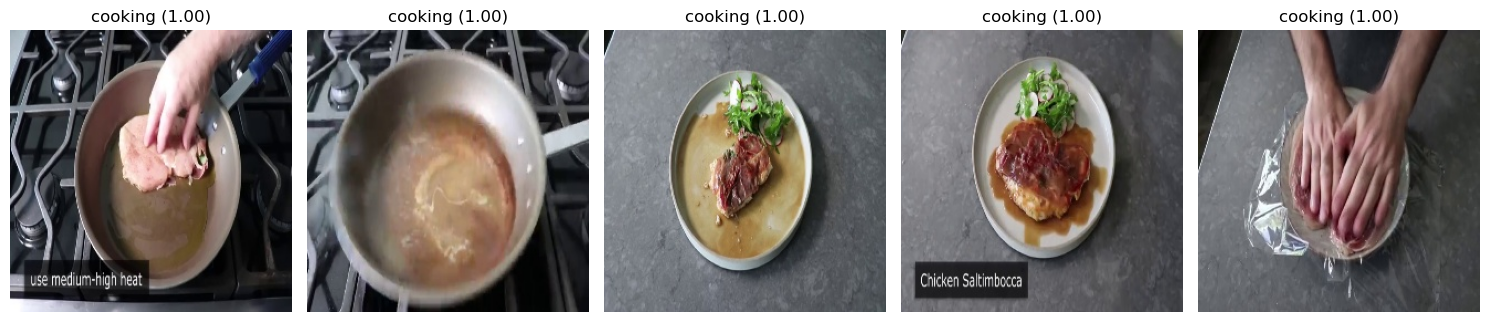

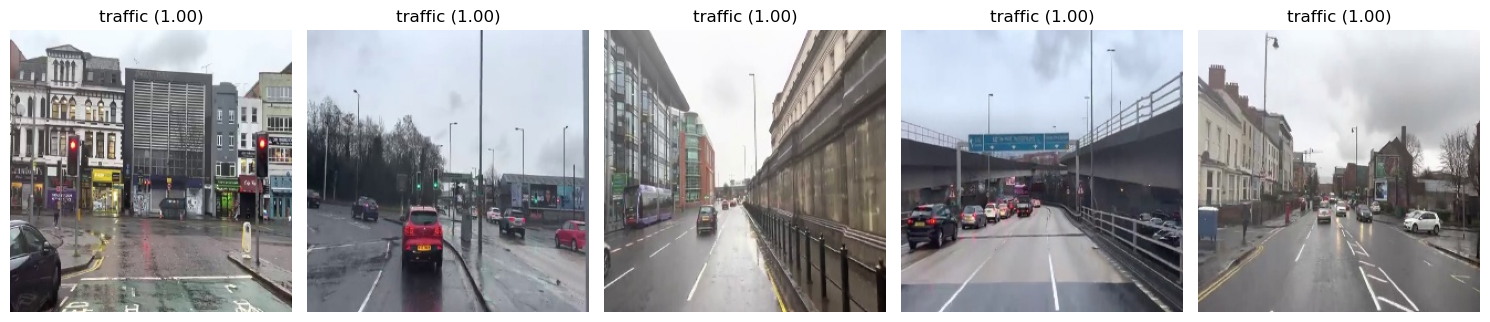

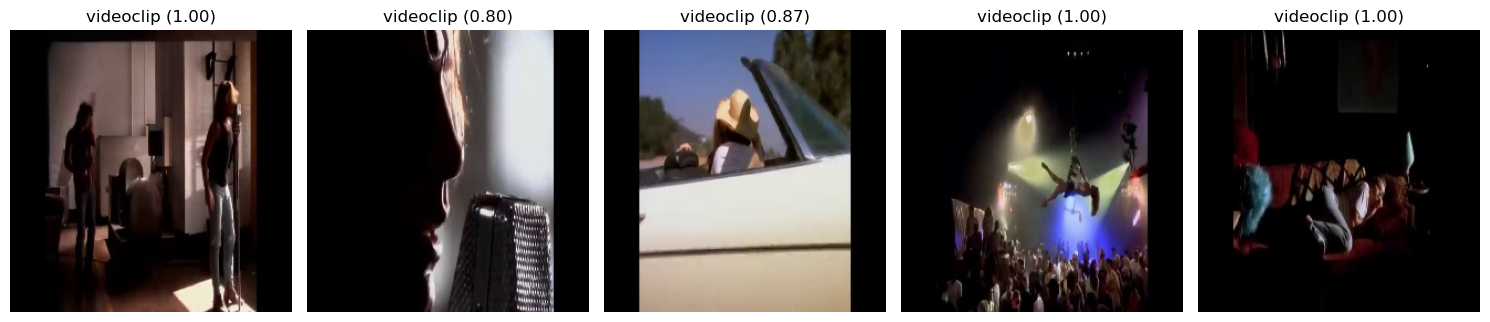

In [34]:
def display_category_sample(category_path, category_output_dir, n=5):
    # Video aleatorio de la categoría
    video_dirs = [dr for dr in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, dr))]         # Obtiene los directorios de videos en la categoría y
    if not video_dirs:                                                                                              # verifica si existen videos dentro
        print(f"No se encontraron videos en {category_path}")
        return
    
    selected_video = random.choice(video_dirs)                                                                      # barajamos y seleccionamos un video aleatorio
    video_dir_path = os.path.join(category_path, selected_video)                                                    # y creamos la ruta completa del video seleccionado

    # Buscar el CSV correspondiente al video
    csv_file_path = os.path.join(category_output_dir, f"{selected_video}.csv")                                      # selecciona el archivo CSV correspondiente al video
    if not os.path.exists(csv_file_path):                                                                           # verificando si existe
        print(f"No se encontró el archivo CSV para el video {selected_video}")
        return

    # Datos CSV y seleccion de muestra
    df = pd.read_csv(csv_file_path)                                                                                 # carga el conjunto
    sample = df.sample(min(n, len(df)))                                                                             # y selecciona unas filas asegurándose de no pedir más muestras de las que hay.

    # Mostrar las imágenes
    plt.figure(figsize=(15, 10))                                                                                    # Ploteamos una figura.
    for i, (_, row) in enumerate(sample.iterrows(), 1):                                                             # Iteramos sobre las filas de la muestra,
        frame_path = os.path.join(video_dir_path, row['frame_id'])                                                  # creamos la ruta completa del frame,
        img = Image.open(frame_path)                                                                                # y abrimos la imagen.

        plt.subplot(1, n, i)                                                                                        # Creamos un subplot para cada imagen,
        plt.imshow(img)                                                                                             # mostramos la imagen,
        plt.title(f"{row['predicted_class']} ({row['confidence']:.2f})")                                            # asignamos el título con la clase predicha y la confianza,
        plt.axis('off')                                                                                             # y ocultamos los ejes.
    plt.tight_layout()
    plt.show()

# Iteramos sobre las categorías
for category in os.listdir(processed_data_path):
    category_path = os.path.join(processed_data_path, category)
    category_output_dir = os.path.join(detection_results_path, category)
    
    if os.path.isdir(category_path):
        display_category_sample(category_path, category_output_dir, n=5)


### Distribución de Clases  

Generamos **gráficos de barras** para analizar la **distribución de frames clasificados** por categoría.

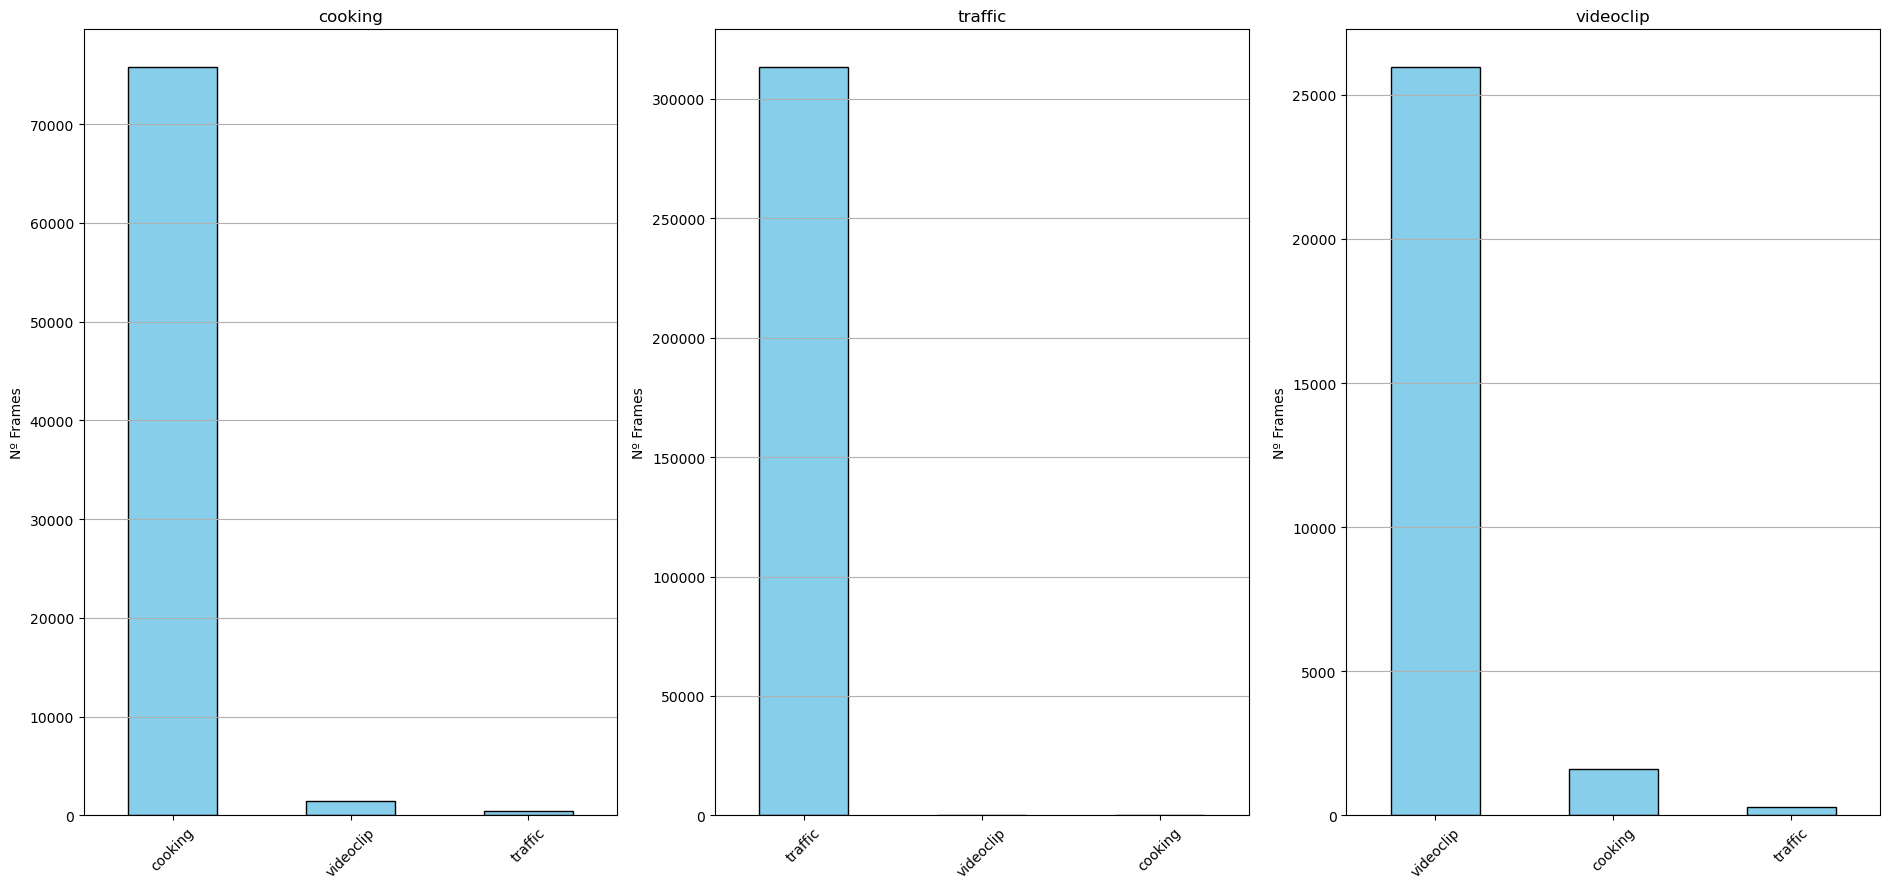

In [21]:
def plot_category_distributions_in_grid(detection_results_path):
    # Extraemos las categorias
    categories = [cat for cat in os.listdir(detection_results_path) if os.path.isdir(os.path.join(detection_results_path, cat))]

    # Configuración de la rejilla (1 fila x 3 columnas)
    n_cols = 3 
    n_rows = math.ceil(len(categories) / n_cols)                                            # Calculamos el número de filas necesarias para mostrar todas las categorías

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(19, 9 * n_rows))                      # Creamos una figura y una rejilla de subplots
    axes = axes.flatten()                                                                   # y aplanamos para indexar más fácilmente

    for idx, category in enumerate(categories):                                             # iteramos sobre las categorías y sus índices
        category_dir = os.path.join(detection_results_path, category)                       # y creamos la ruta completa

        # Combinamos CSVs de categoría
        all_data = []                                                                       # Inicializamos una lista para almacenar los DFs
        for csv_file in os.listdir(category_dir):                                           # e iteramos sobre los archivos CSV en la categoría.
            if csv_file.endswith('.csv'):                                                   # Verrificamos si se trata de un .csv
                csv_path = os.path.join(category_dir, csv_file)                             # y cramos la ruta completa al archivo CSV
                df = pd.read_csv(csv_path)                                                  # lee el archivo
                all_data.append(df)                                                         # y agregamos a la lista

        if not all_data: 
            print(f"No hay archivos en el CSV de {category_dir}")
            continue
        
        # Concatenar todos los DataFrames
        combined_df = pd.concat(all_data, ignore_index=True)                                

        # Calcular la distribución de las clases
        class_counts = combined_df['predicted_class'].value_counts()

        # Graficado
        ax = axes[idx]                                                                      # extraemos el eje correspondiente al índice
        class_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)
        ax.set_title(f"{category}")
        ax.set_xlabel("")
        ax.set_ylabel("Nº Frames")
        ax.tick_params(axis='x', rotation=45) 
        ax.grid(axis='y')

    for ax in axes[len(categories):]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

plot_category_distributions_in_grid(detection_results_path)

En la gráfica, podemos ver cómo **se distribuyen los frames procesados** entre las diferentes categorías. **Se nota claramente** que *traffic* es la categoría con **más frames**, lo que sugiere que incluye **videos más largos**. Por otro lado, *videoclips* está en el extremo opuesto, con la **menor cantidad de frames**, lo que indica que se trata de **videos más cortos**.  

En general, el proceso de clasificación **ha funcionado bastante bien**. El algoritmo ha conseguido **clasificar correctamente la mayoría de los frames**, lo que demuestra un **buen desempeño**. 

### Evaluación de Confianza


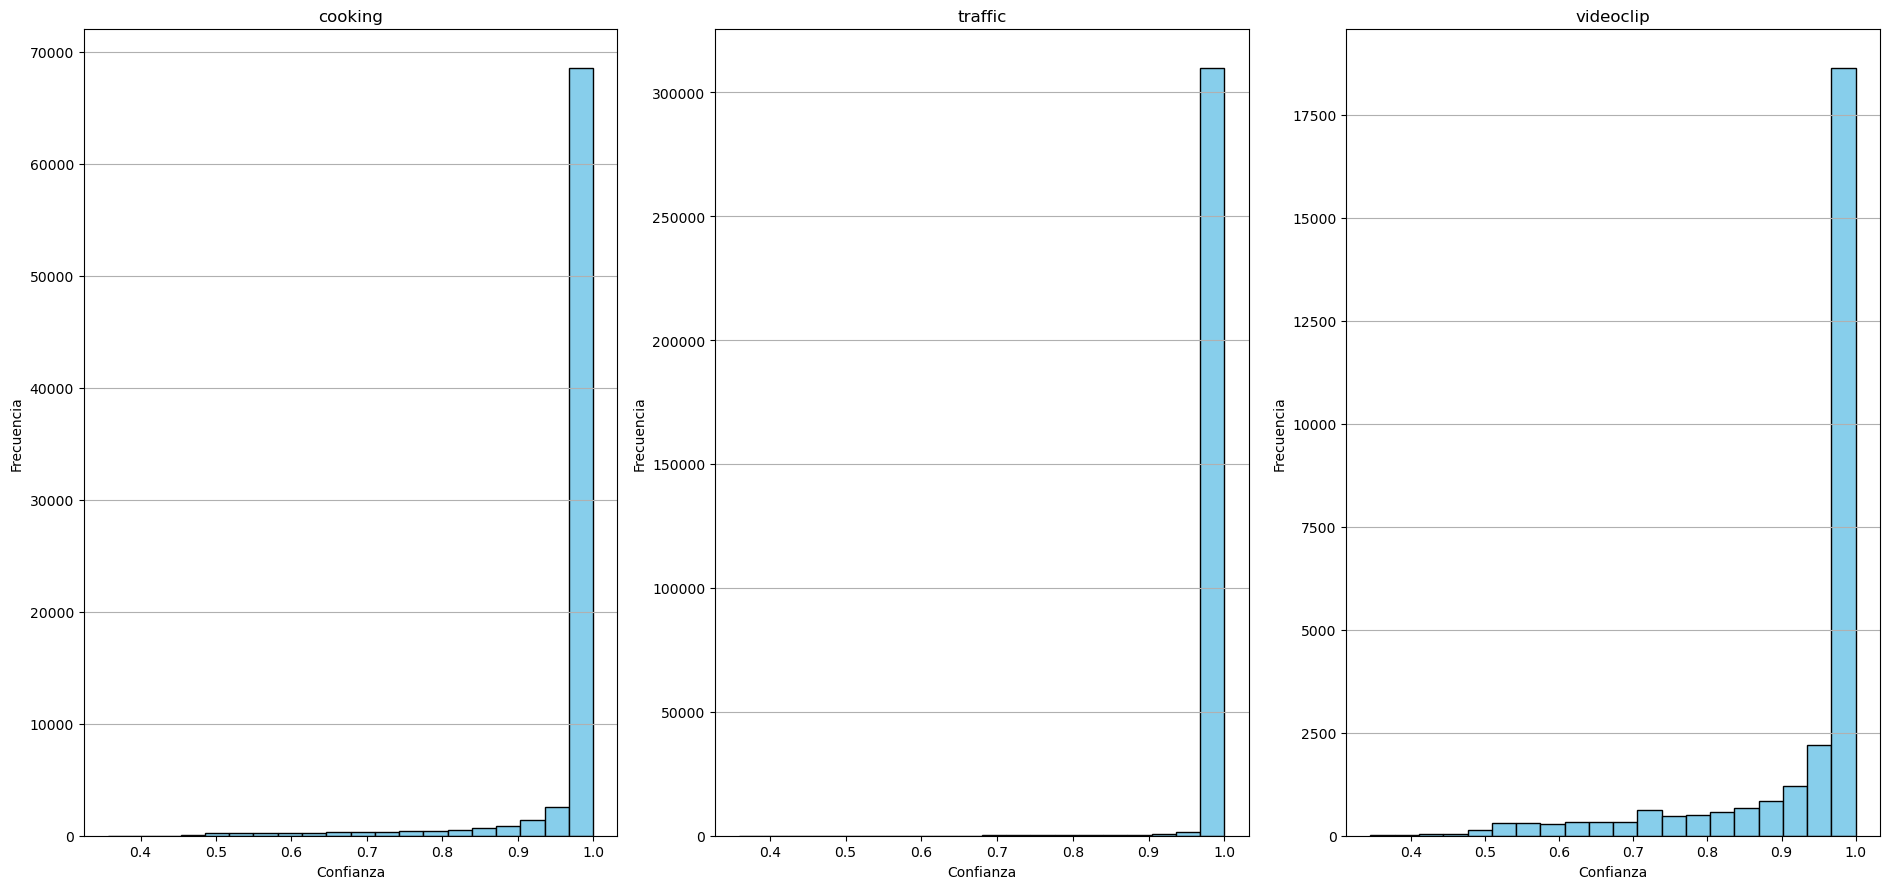

In [38]:
def plot_confidence_distributions_in_grid(detection_results_path):
    # Extraemos las categorias
    categories = [cat for cat in os.listdir(detection_results_path) if os.path.isdir(os.path.join(detection_results_path, cat))]

    # Configuración de la rejilla (1 fila x 3 columnas)
    n_cols = 3
    n_rows = math.ceil(len(categories) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(19, 9 * n_rows))
    axes = axes.flatten()

    for idx, category in enumerate(categories):
        category_dir = os.path.join(detection_results_path, category)

        # Combinamos todas las confianzas de la categoría
        all_confidences = []
        for csv_file in os.listdir(category_dir):                                       # Iteramos sobre los CSVs
            if csv_file.endswith('.csv'):                                               # verificando que sean CSVs
                csv_path = os.path.join(category_dir, csv_file)                         # si los son, creamos la ruta,
                df = pd.read_csv(csv_path)                                              # lee el archivo,
                all_confidences.extend(df['confidence'].tolist())                       # y agregamos las confianzas a la lista.

        if not all_confidences:
            print(f"No se encontraron datos de confianza en {category_dir}")
            continue

        # Graficado
        ax = axes[idx]
        ax.hist(all_confidences, bins=20, color='skyblue', edgecolor='black')
        ax.set_title(f"{category}")
        ax.set_xlabel("Confianza")
        ax.set_ylabel("Frecuencia")
        ax.grid(axis='y')

    for ax in axes[len(categories):]:
        fig.delaxes(ax)
        
    plt.tight_layout()
    plt.show()

plot_confidence_distributions_in_grid(detection_results_path)

La **confianza general del modelo es alta**, pero *Videoclip* podría ser una **categoría más difícil de clasificar**, posiblemente requiriendo **más datos** o un **mayor ajuste** para mejorar su desempeño.